In [28]:
# -*- coding:utf-8 -*-
# @Python Version: 3.7
# @Time: 2020/12/3 19:52
# @Author: Michael Ming
# @Website: https://michael.blog.csdn.net/
# @File: emotion_analysis.py
# @Reference:

import numpy as np
import pandas as pd

data = pd.read_csv("yelp_labelled.txt", sep='\t', names=['sentence', 'label'])

data.head() # 1000条数据

,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [29]:
# 数据 X 和 标签 y
sentence = data['sentence'].values
label = data['label'].values

In [30]:
# 训练集 测试集拆分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentence, label, test_size=0.3, random_state=1)

In [31]:
# 文本向量化
import keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train) # 训练tokenizer
X_train = tokenizer.texts_to_sequences(X_train) # 转成 [ids...]
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index)+1

In [32]:
maxlen = 100
# pad 保证每个句子的长度相等
from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
# post 尾部补0，pre 前部补0
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

In [33]:
from keras import layers
embeddings_dim = 150
filters = 64
kernel_size = 5
batch_size = 64


nn_model = keras.Sequential()
nn_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embeddings_dim, input_length=maxlen))
nn_model.add(layers.Conv1D(filters=filters,kernel_size=kernel_size,activation='relu'))
nn_model.add(layers.GlobalMaxPool1D())
nn_model.add(layers.Dropout(0.3))
# 上面 GlobalMaxPool1D 后，维度少了一维，下面自定义layers再扩展一维
nn_model.add(layers.Lambda(lambda x : keras.backend.expand_dims(x, axis=-1)))
nn_model.add(layers.Conv1D(filters=filters,kernel_size=kernel_size,activation='relu'))
nn_model.add(layers.GlobalMaxPool1D())
nn_model.add(layers.Dropout(0.3))
nn_model.add(layers.Dense(10, activation='relu'))
nn_model.add(layers.Dense(1, activation='sigmoid')) # 二分类sigmoid, 多分类 softmax

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 150)          251400    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 64)            48064     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 64, 1)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 60, 64)            384       
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)               

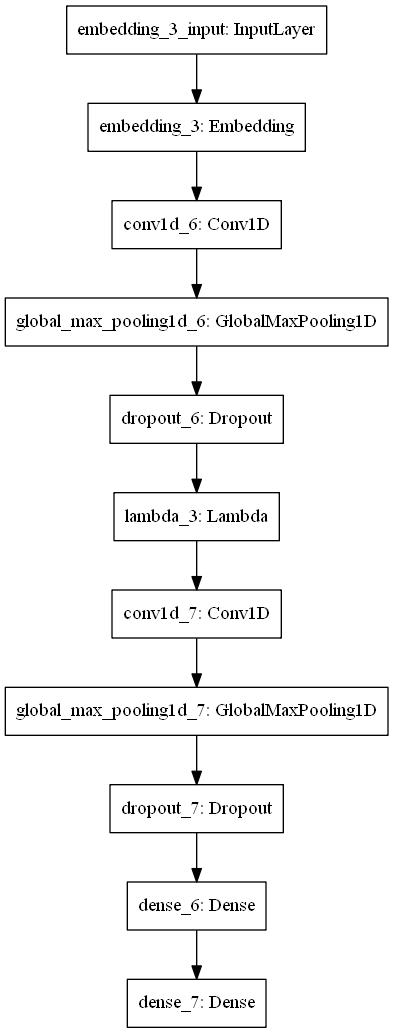

In [34]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
nn_model.summary()
from keras.utils import plot_model
plot_model(nn_model, to_file='model.jpg')


Epoch 1/50
11/11 - 1s - loss: 0.6935 - accuracy: 0.4871 - val_loss: 0.6937 - val_accuracy: 0.4633
Epoch 2/50
11/11 - 0s - loss: 0.6929 - accuracy: 0.5243 - val_loss: 0.6943 - val_accuracy: 0.4633
Epoch 3/50
11/11 - 0s - loss: 0.6923 - accuracy: 0.5143 - val_loss: 0.6945 - val_accuracy: 0.4633
Epoch 4/50
11/11 - 0s - loss: 0.6912 - accuracy: 0.5157 - val_loss: 0.6953 - val_accuracy: 0.4633
Epoch 5/50
11/11 - 0s - loss: 0.6892 - accuracy: 0.5171 - val_loss: 0.6940 - val_accuracy: 0.4633
Epoch 6/50
11/11 - 0s - loss: 0.6838 - accuracy: 0.5229 - val_loss: 0.6905 - val_accuracy: 0.4633
Epoch 7/50
11/11 - 0s - loss: 0.6718 - accuracy: 0.5343 - val_loss: 0.6834 - val_accuracy: 0.4733
Epoch 8/50
11/11 - 0s - loss: 0.6438 - accuracy: 0.5786 - val_loss: 0.6672 - val_accuracy: 0.5600
Epoch 9/50
11/11 - 0s - loss: 0.6063 - accuracy: 0.6529 - val_loss: 0.6431 - val_accuracy: 0.5700
Epoch 10/50
11/11 - 0s - loss: 0.5405 - accuracy: 0.7657 - val_loss: 0.6092 - val_accuracy: 0.6500
Epoch 11/50
11/11 -

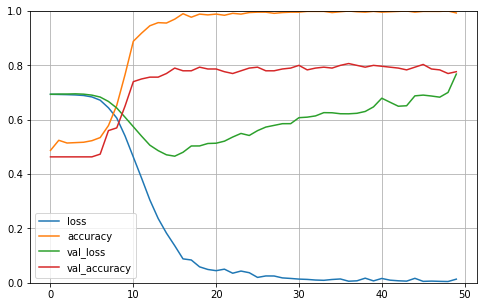

In [35]:
history = nn_model.fit(X_train,y_train,batch_size=batch_size,
             epochs=50,verbose=2,validation_data=(X_test,y_test))
# verbose 是否显示日志信息，0不显示，1显示进度条，2不显示进度条
loss, accuracy = nn_model.evaluate(X_train, y_train, verbose=1)
print("训练集：loss {0:.3f}, 准确率：{1:.3f}".format(loss, accuracy))
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=1)
print("测试集：loss {0:.3f}, 准确率：{1:.3f}".format(loss, accuracy))

from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [36]:
text = ["i am not very good.", "i am very good."]
x = tokenizer.texts_to_sequences(text)
x = pad_sequences(x, maxlen=maxlen, padding='post')
pred = nn_model.predict(x)
print("预测{}的类别为：".format(text[0]), 1 if pred[0][0]>=0.5 else 0)
print("预测{}的类别为：".format(text[1]), 1 if pred[1][0]>=0.5 else 0)


预测i am not very good.的类别为： 0
预测i am very good.的类别为： 1
